In [1]:
%matplotlib inline
from defs import *

In [2]:
counts_data=df=pd.read_excel('data_Ilan_Gospels_Josephus_Apocrypha.xlsx')
# Example usage
df_display(df, head=10, tail=10)

,Name,Ilan,Gospels,Josephus,Apocrypha
0,Simon,184,8,21,9
1,Joseph,171,6,16,9
2,Eleazar,135,1,15,4
3,Judah,126,5,10,7
4,Yohanan,103,5,9,5
5,Hananiah,74,2,10,3
6,Joshua,68,2,12,2
7,Jonathan,56,1,7,1
8,Mattathias,50,2,7,3
9,Jacob,30,5,4,6


In [3]:
def ilan_uniform_mixture_model(y=None, y_exp=None, N=None, K=None,m=None):

    if m==0:
        # Dirichlet prior for the first m categories
        # Uniform probabilities for the remaining K-m categories
        theta_uniform = numpyro.deterministic("theta_uniform", np.ones(K) / K)
        # Combine the two components into a single probability vector
        theta = numpyro.deterministic("theta", theta_uniform)

    else:
        # Dirichlet prior for the first m categories
        alpha = numpyro.sample("alpha", dist.Exponential(1.0).expand([m]))
        theta_dirichlet = numpyro.sample("theta_dirichlet", dist.Dirichlet(alpha))
        
        # Uniform probabilities for the remaining K-m categories
        theta_uniform = numpyro.deterministic("theta_uniform", np.ones(K - m) / (K - m))

        # Weight parameter: how much mass goes to the first m categories
        w = numpyro.sample("w", dist.Beta(2, 2))  # optional: can fix to 0.5 if you prefer
    
        
        # Combine the two components into a single probability vector
        theta = numpyro.deterministic("theta", jnp.concatenate([w * theta_dirichlet, (1-w)*theta_uniform]))
    
    # Candidate rolls used to update Dirichlet priors
    numpyro.sample("y_exp", dist.Multinomial(total_count=y_exp.sum(), probs=theta), obs=y_exp)
    
    # Multinomial likelihood
    numpyro.sample("y", dist.Multinomial(total_count=N, probs=theta), obs=y)


In [4]:
cols=df.columns
cols

Index(['Name', 'Ilan', 'Gospels', 'Josephus', 'Apocrypha'], dtype='object')

In [18]:
col='Apocrypha'
sample=df[col].values
population=df['Ilan'].values-sample
population[population<0]=0
names=df['Name'].values    


In [19]:
sample[idx]
df['Ilan'].values[idx]

array([1])

array([], dtype=object)

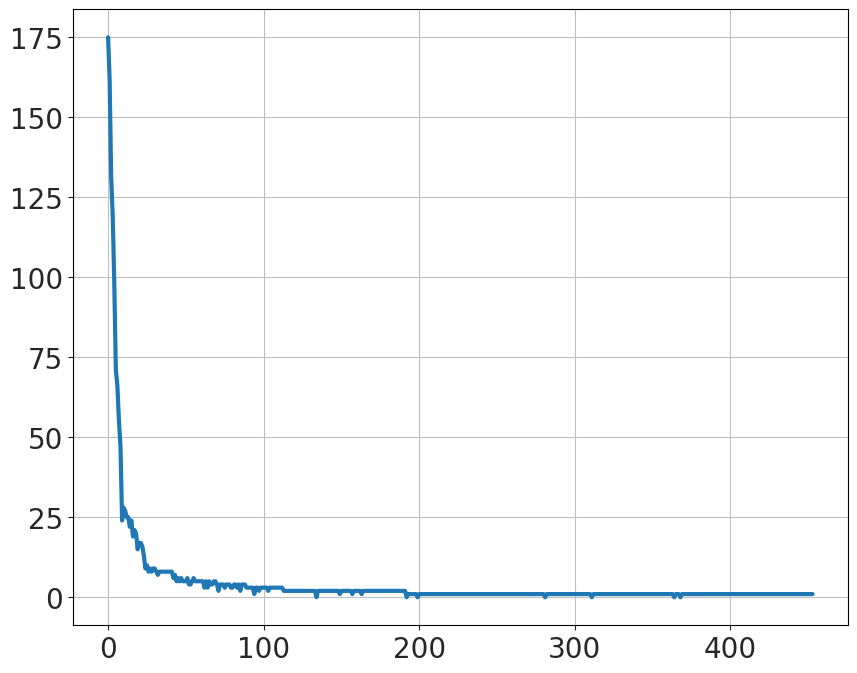

In [20]:
plot(population)
idx=population<0
names[idx]

## Do a quick one

In [23]:
for col in cols[4:]:

    print(col)
    
    sample=df[col].values
    population=df['Ilan'].values-sample
    population[population<0]=0  # one weird name in apocrypha, because of the way I am using Ilan
    names=df['Name'].values    
    
    K = len(sample)  # Number of categories
    N = sum(sample)  # Total number of observations
    y_obs=sample
    y_exp=population


    S=Storage()
    mm=list(arange(0,30))    

    for m in tqdm(mm):   
        mcmc=MCMCModel(ilan_uniform_mixture_model)
        mcmc.run(num_warmup=1000, num_samples=4000,progress_bar=False,
                 y=y_obs,y_exp=y_exp,N=N,K=K,m=m)
        
        bic=mcmc.bic
        aic=mcmc.aic
        S+=m,bic,aic
    
    m,bic,aic=S.arrays()
    
    break

Apocrypha


 87%|█████████████████████████████████████▎     | 26/30 [01:11<00:11,  2.76s/it]

KeyboardInterrupt



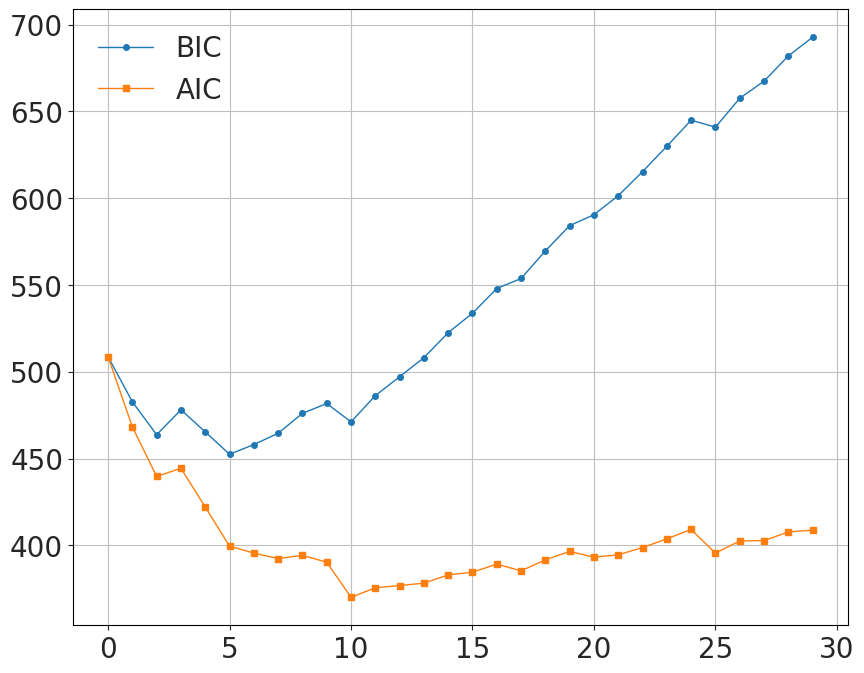

In [6]:
plot(m,bic,'-o',ms=4,lw=1,label='BIC')
plot(m,aic,'-s',ms=4,lw=1,label='AIC')
title(col)
legend()

## All docs

In [5]:
result_full={}

In [26]:
for col in cols[2:]:

    print(col)
    
    sample=df[col].values
    population=df['Ilan'].values-sample
    population[population<0]=0  # one weird name in apocrypha, because of the way I am using Ilan
    names=df['Name'].values    
    
    if col in result_full:
        print("Already done",col)
        continue

    print(col)
    
    K = len(sample)  # Number of categories
    N = sum(sample)  # Total number of observations
    y_obs=sample
    y_exp=population


    S=Storage()
    mm=list(arange(0,K))
    if K not in mm:
        mm.append(K)
    

    for m in tqdm(mm):   
        mcmc=MCMCModel(ilan_uniform_mixture_model)
        mcmc.run(num_warmup=100, num_samples=2000,progress_bar=False,
                 y=y_obs,y_exp=y_exp,N=N,K=K,m=m)
        
        bic=mcmc.bic
        S+=m,bic
    
    m,bic=S.arrays()

    result_full[col]=m,bic
    

Gospels
Already done Gospels
Josephus
Already done Josephus
Apocrypha
Apocrypha


100%|█████████████████████████████████████████| 455/455 [33:18<00:00,  4.39s/it]


In [27]:
from json_tricks import dump,load
with open("bic_result_full_2025-06-27.json", "w") as f:
    dump(result_full, f, indent=4)

In [28]:
with open("bic_result_full_2025-06-27.json") as f:
    res=load(f)

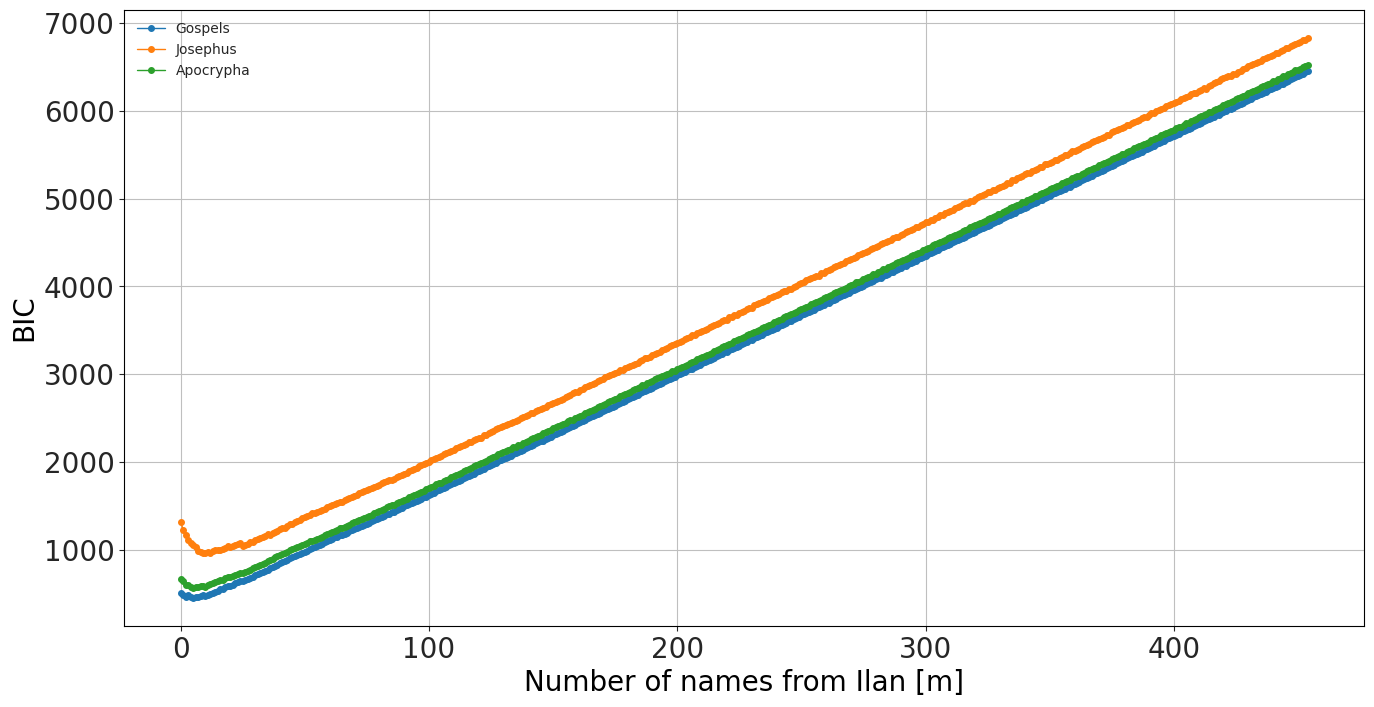

In [29]:
figure(figsize=(16,8))
for col in res:
    m,bic=res[col]
    plot(m,bic,'-o',label=col,ms=4,lw=1)
    legend()
    ylabel('BIC')
    xlabel('Number of Ilan Names ($m$)')    
xlabel('Number of names from Ilan [m]')
legend(fontsize=10)


Gospels 5
Josephus 9
Apocrypha 5


(0.0, 2000.0)

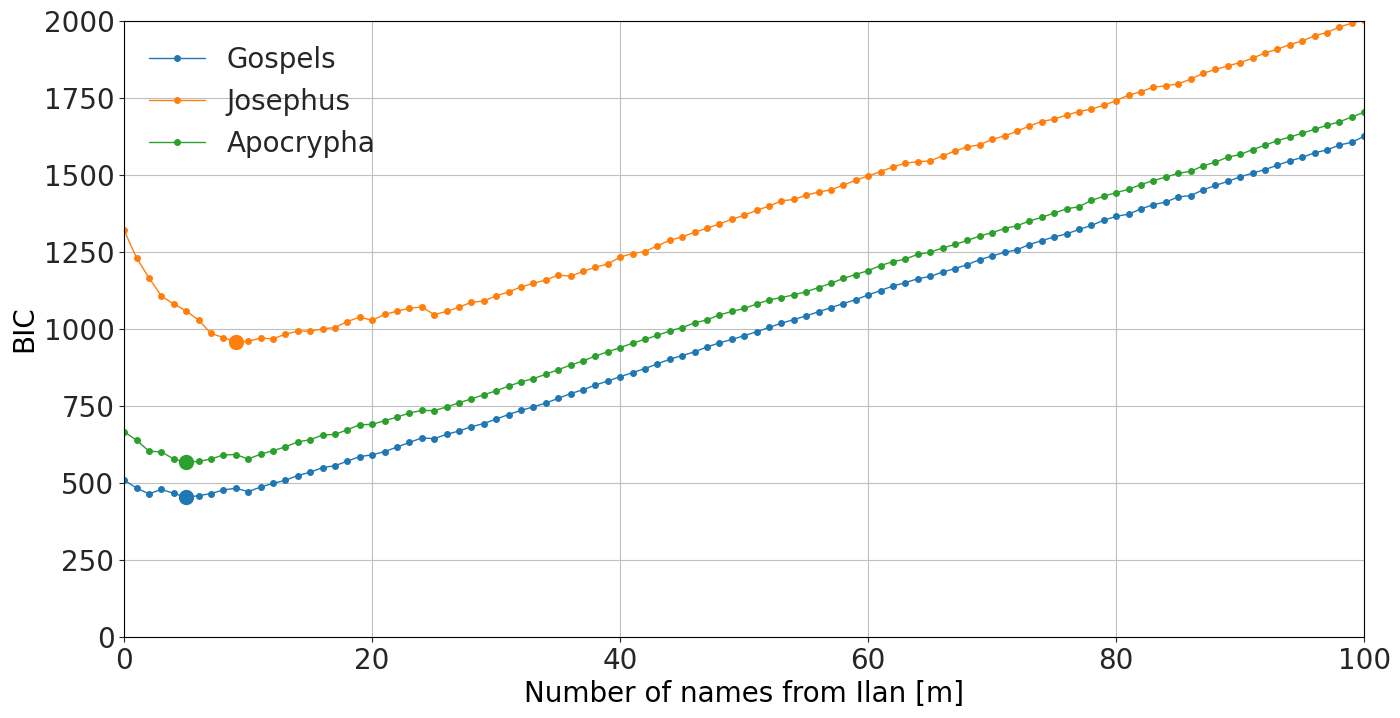

In [37]:
figure(figsize=(16,8))
for col in res:
    m,bic=res[col]
    h=plot(m,bic,'-o',label=col,ms=4,lw=1)
    color=h[0].get_color()
    legend()
    ylabel('BIC')
    xlabel('Number of Ilan Names ($m$)')    

    idx=argmin(bic)
    plot(m[idx],bic[idx],'o',color=color,ms=10)
    print(col,m[argmin(bic)])
    
xlabel('Number of names from Ilan [m]')
legend(fontsize=20)
xlim([0,100])
ylim([0,2000])

